# Import requirements

In [2]:
from __future__ import division
import glob
import pandas as pd
import numpy as np
import itertools
from collections import Counter
import operator
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# set fonts
mpl.rc('font',family='Arial')

# Import data

In [3]:
NGScounts_df = pd.read_csv('/Users/greg/Desktop/FullNeuroIllumina/MergedData/NGS_GDS_counts.csv')
print NGScounts_df.shape
NGScounts_df.head()

(5608, 57)


,Patient,Visit,DateOfVisit,Age,Gender,ART,VL,iVL,pVL,CD4,...,L,K,M,F,P,S,T,W,Y,V
0,A0001,R09,2014-11-10,59,Male,on,20,987,987,797,...,270,66,22002,1,0,33,5,16223,0,8
1,A0010,R08,2014-11-12,59,Male,on,20,50,470,1167,...,1,1,100,0,0,0,0,69,0,0
2,A0013,R09,2014-11-10,68,Male,on,20,144,39373,771,...,1,3,170,0,0,1,0,126,0,0
3,A0019,R12,2015-02-02,46,Female,on,20,99,164020,1130,...,12,5,782,0,0,2,1,672,0,0
4,A0026,R09,2015-04-30,55,Male,on,67859,100000,100000,137,...,3,0,197,0,0,1,0,130,0,0


# Define diversity functions

In [4]:
# calculate diversity using a dictionary object as input
def diversity_column(counts, hill):
    vals = np.array(counts.values(), dtype=np.float64)
    vals /= vals.sum()
    if hill == 1:
        return np.exp(-np.sum(vals*np.log(vals)))
    else:
        return (vals**hill).sum()**(1/(1-hill))

# drop empty keys
def modify_dict(d):
    for k,v in d.items():
        if v == 0.0:
           del d[k]
    return d

In [5]:
def getIntrapatientDiversity(counts_df, hill_number):
    cols = ['A','R','N','D','C','Q','E','G','H','I',
            'L','K','M','F','P','S','T','W','Y','V']
    diversity_dict = {'Position':[], 'Diversity':[]}
    
    for i, g in counts_df.groupby('AAPos'):
        for j, row in g.iterrows():
            d = row[cols].to_dict()
            d2 = modify_dict(d)
            div = diversity_column(d2, hill_number)
            diversity_dict['Position'].append(i)
            diversity_dict['Diversity'].append(div)
            
    divDF = pd.DataFrame(diversity_dict)
    div_dict2 = {'Position':[], 'Mean Diversity':[], 'Std Diversity':[],
             'Minimum':[], 'Maximum':[]}

    # information to return
    for i, g in divDF.groupby('Position'):
        div_dict2['Position'].append(int(i))
        div_dict2['Mean Diversity'].append(np.mean(g['Diversity']))
        div_dict2['Std Diversity'].append(np.std(g['Diversity']))
        div_dict2['Minimum'].append(min(g['Diversity']))
        div_dict2['Maximum'].append(max(g['Diversity']))
    divDF2 = pd.DataFrame(div_dict2)
    return divDF2

In [6]:
divDF = getIntrapatientDiversity(NGScounts_df, 1)
divDF.head()

,Maximum,Mean Diversity,Minimum,Position,Std Diversity
0,3.263540,2.402391,1.042956,1,0.436168
1,3.956289,2.348515,1.037875,2,0.470407
2,2.343459,2.024093,1.034579,3,0.246198
3,2.312312,1.266866,1.000000,4,0.344993
4,2.246121,1.393548,1.069108,5,0.343414


# Plot intrapatient diversity

/Users/greg/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


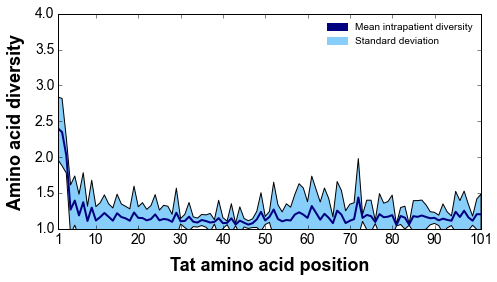

In [7]:
fig, ax = plt.subplots(figsize=(7,4))
L = list(divDF['Mean Diversity'])
L2 = [0] + L
E = list(divDF['Std Diversity'])
E2 = [0] + E

y = np.array(L2)
x = np.arange(len(L2))
miny = y - np.array(E2)
maxy = y + np.array(E2)

# plot it
ax.tick_params(axis='both',labelsize=14)
ax.plot(x, y, linewidth=2, color='navy')
yerr = E2
ax.fill_between(x, miny, maxy,facecolor='lightskyblue')
ax.set_ylabel('Amino acid diversity',size=18, labelpad=10, weight='bold')
ax.set_ylim([1,4])
ax.set_xlabel('Tat amino acid position', size=18, labelpad=10, weight='bold')
xs = [1,10,20,30,40,50,60,70,80,90,101]
ax.set_xticks(xs)
ax.set_xlim([1,101])

ax.legend([mpl.patches.Patch(color='navy'),
           mpl.patches.Patch(color='lightskyblue')],
           ['Mean intrapatient diversity', 'Standard deviation'],
           loc=1, ncol=1, fancybox=False, frameon=False,
           fontsize=10)

plt.tight_layout()
plt.show()
fig.savefig('/Users/greg/Desktop/TatFigureStuff/illuminadiversity.png',
            format='png', dpi=300, bbox_inches='tight')

# Interpatient diversity

In [59]:
cols = ['A','R','N','D','C','Q','E','G','H','I','L','K','M','F','P','S','T','W','Y','V']

inter_intra_dict = {'Position':[], 'InterDiversity':[], 'IntraDiversity':[], 'Variants':[]}
for i, g in NGScounts_df.groupby('AAPos'):
    Alist = []
    for j, row in g.iterrows():
        d = row[cols].to_dict()
        d2 = modify_dict(d)
        div_round = int(round(diversity_column(d2, 1)))
        sorted_d = sorted(d2.items(), key=operator.itemgetter(1), reverse=True)
        top_variants = [var[0] for var in sorted_d[:div_round]]
        Alist += top_variants
    Adict = dict(Counter(Alist))
    sorted_Adict = sorted(Adict.items(), key=operator.itemgetter(1), reverse=True)
    Alist = [x[0] for x in sorted_Adict]
    inter_div = diversity_column(Adict, 1)
    intra_div = list(divDF[divDF['Position'] == int(i)]['Mean Diversity'])[0]
    
    # append to dictionary
    inter_intra_dict['Position'].append(int(i))
    inter_intra_dict['InterDiversity'].append(inter_div)
    inter_intra_dict['IntraDiversity'].append(intra_div)
    inter_intra_dict['Variants'].append(Alist)
    
inter_intra_diversity_df = pd.DataFrame(inter_intra_dict)

# Plot Inter- vs Intra- patient diversity

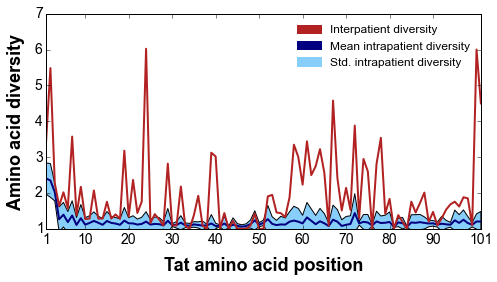

In [10]:
fig, ax = plt.subplots(figsize=(7,4))

inter = list(inter_intra_diversity_df['InterDiversity'])
L1 = [0] + inter
y1 = np.array(L1)

L = list(divDF['Mean Diversity'])
E = list(divDF['Std Diversity'])
L2 = [0] + L
E2 = [0] + E


y = np.array(L2)
y1 = np.array(L1)
x = np.arange(len(L2))
miny = y - np.array(E2)
maxy = y + np.array(E2)

# plot it
ax.tick_params(axis='both',labelsize=14)
ax.plot(x, y, linewidth=2, color='navy')
ax.plot(x, y1, linewidth=2, color='firebrick')
yerr = E2
ax.fill_between(x, miny, maxy,facecolor='lightskyblue')
ax.set_ylabel('Amino acid diversity',size=18, labelpad=10, weight='bold')
ax.set_ylim([1,7])
ax.set_xlabel('Tat amino acid position', size=18, labelpad=10, weight='bold')
xs = [1,10,20,30,40,50,60,70,80,90,101]
ax.set_xticks(xs)
ax.set_xlim([1,101])

ax.legend([mpl.patches.Patch(color='firebrick'),
           mpl.patches.Patch(color='navy'),
           mpl.patches.Patch(color='lightskyblue')],
           ['Interpatient diversity','Mean intrapatient diversity', 'Std. intrapatient diversity'],
           loc=1, ncol=1, fancybox=False, frameon=False,
           fontsize=12)

plt.tight_layout()
plt.show()
fig.savefig('/Users/greg/Desktop/TatFigureStuff/diversity_comparisons.png',
            format='png', dpi=300, bbox_inches='tight')

In [11]:
inter_intra_diversity_df.to_csv('/Users/greg/Desktop/FullNeuroIllumina/Diversity/diversitydf.csv', index=False)

# Diversity Filter

In [13]:
div_df = inter_intra_diversity_df
div_df.tail()

,InterDiversity,IntraDiversity,Position
96,1.880587,1.251962,97
97,1.848753,1.159998,98
98,1.093713,1.112816,99
99,6.001250,1.204232,100
100,4.497453,1.202207,101


In [17]:
DF = pd.read_csv('/Users/greg/Desktop/FullNeuroIllumina/MergedData/NGS_GDS_abundance.csv')

# trim columns
C = ['Patient','Visit','DateOfVisit','Age','Gender','ART','VL','iVL','pVL',
     'CD4','iCD4','nCD4','CD8','iCD8','nCD8','TMHDS','VisitDate','GDS','Prot', 
     'AAPos','Coverage','A','R','N','D','C','Q','E','G','H','I','L','K','M',
     'F','P','S','T','W','Y','V']
DF = DF[C]
print DF.shape
DF.tail()

(5608, 41)


,Patient,Visit,DateOfVisit,Age,Gender,ART,VL,iVL,pVL,CD4,...,L,K,M,F,P,S,T,W,Y,V
5603,A0421,R04,2014-09-03,63,Male,on,20,50,110,532,...,0.000674,0.000000,0,0,0.000337,0.000135,0.000000,0,0.000000,0.000337
5604,A0465,R03,2015-04-09,46,Female,on,20,1757650,1757650,687,...,0.000328,0.000000,0,0,0.000000,0.000000,0.000000,0,0.000000,0.001966
5605,A0490,R02,2015-01-05,47,Male,on,20,100,100,1129,...,0.002589,0.000000,0,0,0.000401,0.000766,0.000328,0,0.000292,0.000000
5606,A0500,R03,2015-02-19,47,Female,on,20,1330,4726,734,...,0.000110,0.000000,0,0,0.985948,0.000110,0.000329,0,0.000000,0.000220
5607,A0505,R02,2014-04-28,57,Male,on,40,24200,46014,644,...,0.005024,0.002512,0,0,0.001005,0.000000,0.000000,0,0.000000,0.001005


In [19]:
diverse_positions = list(div_df[div_df.InterDiversity >= 1.5].Position)
print len(diverse_positions)
print diverse_positions

52
[1, 2, 3, 4, 5, 6, 7, 9, 12, 15, 19, 21, 23, 24, 29, 32, 36, 39, 40, 52, 53, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 70, 71, 72, 74, 75, 77, 78, 80, 85, 87, 88, 93, 94, 95, 96, 97, 98, 100, 101]


In [22]:
divmask = DF['AAPos'].isin(diverse_positions)
filterDF = DF[divmask]
filterDF.to_csv('/Users/greg/Desktop/FullNeuroIllumina/Diversity/filterDF.csv', index=False)
filterDF.tail()

,Patient,Visit,DateOfVisit,Age,Gender,ART,VL,iVL,pVL,CD4,...,L,K,M,F,P,S,T,W,Y,V
5603,A0421,R04,2014-09-03,63,Male,on,20,50,110,532,...,0.000674,0.000000,0,0,0.000337,0.000135,0.000000,0,0.000000,0.000337
5604,A0465,R03,2015-04-09,46,Female,on,20,1757650,1757650,687,...,0.000328,0.000000,0,0,0.000000,0.000000,0.000000,0,0.000000,0.001966
5605,A0490,R02,2015-01-05,47,Male,on,20,100,100,1129,...,0.002589,0.000000,0,0,0.000401,0.000766,0.000328,0,0.000292,0.000000
5606,A0500,R03,2015-02-19,47,Female,on,20,1330,4726,734,...,0.000110,0.000000,0,0,0.985948,0.000110,0.000329,0,0.000000,0.000220
5607,A0505,R02,2014-04-28,57,Male,on,40,24200,46014,644,...,0.005024,0.002512,0,0,0.001005,0.000000,0.000000,0,0.000000,0.001005


# Get diverse AAs in table

In [67]:
DIV_TABLE = inter_intra_diversity_df[inter_intra_diversity_df.InterDiversity >= 1.5]
DIV_TABLE = DIV_TABLE[['Position','IntraDiversity','InterDiversity','Variants']]
DIV_TABLE.set_index(['Position'],inplace=True)
DIV_TABLE.to_csv('/Users/greg/Desktop/FullNeuroIllumina/Diversity/DivTable.csv')
DIV_TABLE

,IntraDiversity,InterDiversity,Variants
Position,,,
1,2.402391,3.433133,"[M, W, I, E, S, L, N]"
2,2.348515,5.483579,"[E, S, D, I, K, N, P, Q, R, T]"
3,2.024093,2.273316,"[P, Q, V]"
4,1.266866,1.637101,"[V, D, I, M]"
5,1.393548,2.018744,"[D, N, P, E]"
6,1.186964,1.576206,"[P, R, H, Q]"
7,1.370217,3.573029,"[R, S, K, L, N, V]"
9,1.295348,2.171352,"[E, K, P, A, D, H]"
12,1.220697,2.070798,"[K, H, E, N, Q, D]"
